Initial Data (first 5 rows):
         gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  gene10
sample1     12     21      4    130     18      0     16     54     49       3
sample2      1     44      2     63     11     10     70     32     57       9
sample3      4      4     11    180     21      3     28     34     65       2
sample4      1     10      2    100     44      9     28     16     33       9
sample5      1     11      6    135     16      2     32     29     31       5

Differential Expression Results (first 10 rows):
       Gene   Log2_FC  Fold_Change   P-value  Adj_P-value
0   sample1 -0.850094     0.554748  0.546202          1.0
1   sample2  1.234341     2.352738  0.320046          1.0
2   sample3 -0.114295     0.923834  0.932549          1.0
3   sample4  0.496461     1.410749  0.677744          1.0
4   sample5  0.110793     1.079822  0.930510          1.0
5   sample6  1.502536     2.833403  0.236271          1.0
6   sample7  0.655294     1.574937  0.614

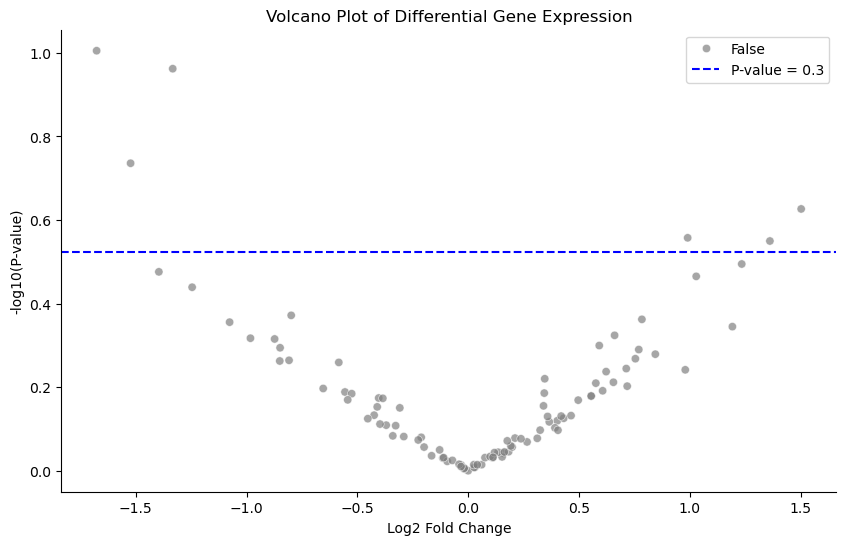

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.utils import load_example_data

# ============================
# Data Initialization
# ============================

# Load example counts dataset
counts_df = load_example_data()

# Recreate metadata (conditions: half Control, half Treatment)
n_samples = counts_df.shape[1]
conditions = ["Control"] * (n_samples // 2) + ["Treatment"] * (n_samples // 2)
metadata_df = pd.DataFrame({"condition": conditions}, index=counts_df.columns)

print("Initial Data (first 5 rows):")
print(counts_df.head())

# ============================
# Differential Expression Analysis
# ============================

# Convert conditions to numeric design matrix
X = pd.get_dummies(metadata_df["condition"], drop_first=True).astype(float)
X = sm.add_constant(X)  # add intercept

# Log2 transform to stabilize variance
df_log = np.log2(counts_df + 1)

# Collect results in list of dicts
results = []

for idx, gene in enumerate(df_log.index, 1):
    y = df_log.loc[gene].values.astype(float)  # response variable
    
    model = sm.OLS(y, X).fit()
    
    log2_fc = model.params.iloc[1]
    fold_change = 2 ** log2_fc
    p_value = model.pvalues.iloc[1]
    
    results.append({
        "Gene": gene,
        "Log2_FC": log2_fc,
        "Fold_Change": fold_change,
        "P-value": p_value
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Adjust p-values using Benjamini-Hochberg (FDR)
results_df["Adj_P-value"] = multipletests(results_df["P-value"], method="fdr_bh")[1]

print("\nDifferential Expression Results (first 10 rows):")
print(results_df.head(10))

# ============================
# Data Visualization
# ============================a

# Volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="Log2_FC",
    y=-np.log10(results_df["P-value"]),
    hue=results_df["Adj_P-value"] < 0.3,
    palette={True: "red", False: "grey"},
    alpha=0.7
)

# Significance threshold line
plt.axhline(y=-np.log10(0.3), color="blue", linestyle="--", label="P-value = 0.3")

# Labels & styling
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(P-value)")
plt.title("Volcano Plot of Differential Gene Expression")
plt.legend()
sns.despine()
plt.show()
